In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt,pow
import pytz
import os
import seaborn as sns

## Loading Data:
- df_gulf: shanghai, gulf, order data
- df_taxi: shanghai, taxi, order data

In [2]:
days = [22,23,24]
frames=[]
types=["gulf","taxi"]
for type in types:
    for day in days:
        path ='/Users/serenazhang/Desktop/didi_project/github/order_data/order_sh_{0}_{1}.csv'.format(day,type)
        col=['order_id','type',"label"]
        frame = pd.read_csv(path,sep=",",usecols=[0,10,11],header=0, names=col)
        frames.append(frame)
df_order= pd.concat(frames)

In [3]:
frames=[]
for type in types:
    for day in days:
        path ='/Users/serenazhang/Desktop/didi_project/github/cleaned/odcleaned_{1}_{0}.txt'.format(day,type)
        col=['order_id','ox','oy','o_time','dx','dy','d_time','path_len','path_time']
        frame = pd.read_csv(path,sep=",",header=1, names=col)
        frames.append(frame)
df= pd.concat(frames)

In [4]:
df=df.merge(df_order, on='order_id',how='inner')

In [5]:
#add column "cnt_of_same_trip" for number of occurence of same label given label number
df['cnt_of_same_trip'] = df.groupby(['label'])["label"].transform('count')
df.loc[df.cnt_of_same_trip>3,'cnt_of_same_trip']=0
#changing time column to datetime object
df['o_time'] = pd.to_datetime(df['o_time'],unit='s',utc=True)
df["o_time"]=df.o_time.dt.tz_localize("UTC").dt.tz_convert(pytz.timezone('Asia/Shanghai'))
df['d_time'] = pd.to_datetime(df['d_time'],unit='s',utc=True)
df["d_time"]=df.d_time.dt.tz_localize("UTC").dt.tz_convert(pytz.timezone('Asia/Shanghai'))
df[["ox","oy","dx","dy"]]=df[["ox","oy","dx","dy"]].astype(float)

## Exploring O1-O2 patterns
#### (For shared trips, O1 is the first origin and O2 is the second origin)
- What's the distrbution of distance between O1-O2?
- What's the distrbution of time between O1-O2?

In [7]:
#assign origin orders
df["shared_order"]=0
gr = df.loc[df["label"]!=0].sort_values('o_time').groupby('label')
df.loc[df["label"]!=0,'shared_order'] = gr.cumcount()

In [42]:
def dis_dif(dd):
    if dd.shape[0]>1:
        fr=dd[dd["shared_order"]==0]
        to=dd[dd["shared_order"]==1]
        result=sqrt(pow((fr.iloc[0]["ox"]-to.iloc[0]["ox"]),2)+pow((fr.iloc[0]["oy"]-to.iloc[0]["oy"]),2))
        return result
def time_dif(dd):
    if dd.shape[0]>1:
        fr=dd[dd["shared_order"]==0]
        to=dd[dd["shared_order"]==1]
        result=(to.iloc[0]["o_time"]-fr.iloc[0]["o_time"]).total_seconds()
        return result

In [38]:
cal_dis=df.loc[df["label"]!=0].groupby("label").apply(dis_dif).reset_index().rename(
    columns={0: 'distance'})
cal_dis=cal_dis[np.abs(cal_dis['distance']-cal_dis['distance'].mean())<=(3*cal_dis['distance'].std())]
cal_dis_array=cal_dis[cal_dis["distance"]>0]["distance"].as_matrix()

In [45]:
cal_time=df.loc[df["label"]!=0].groupby("label").apply(time_dif).reset_index().rename(
    columns={0: 'time'})

In [48]:
cal_time=cal_time[np.abs(cal_time['time']-cal_time['time'].mean())<=(3*cal_time['time'].std())]
cal_time_array=cal_time[cal_time["time"]>0]["time"].as_matrix()

In [46]:
cal_time.time.describe()

count     244.000000
mean      593.639344
std       578.239873
min         6.000000
25%       250.000000
50%       432.000000
75%       764.000000
max      4116.000000
Name: time, dtype: float64

In [28]:
cal_dis.distance.describe()

count     240.000000
mean     1303.685482
std      1423.553370
min         0.000000
25%       387.591120
50%       807.025983
75%      1554.196007
max      6641.440618
Name: distance, dtype: float64

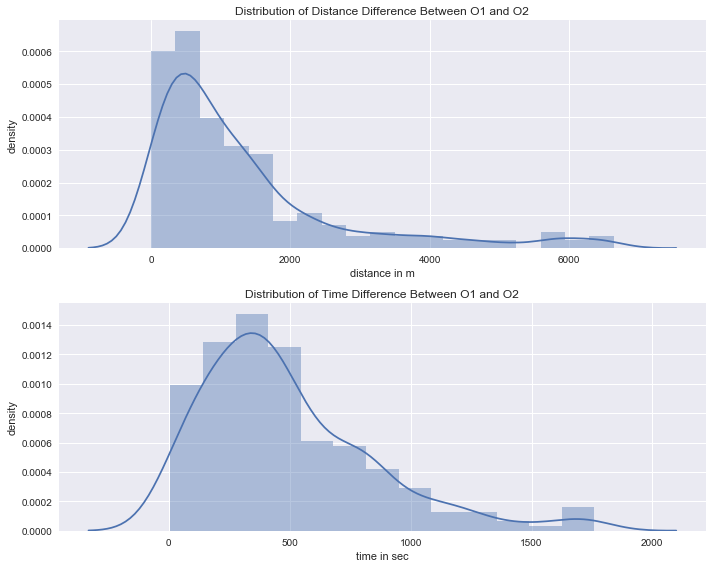

In [61]:
sns.set()
%matplotlib inline
f, (ax1, ax2) = plt.subplots(2,figsize=(10,8))
sns.distplot(cal_dis_array,ax=ax1)
sns.distplot(cal_time_array,ax=ax2)
ax1.set_title("Distribution of Distance Difference Between O1 and O2")
ax2.set_title("Distribution of Time Difference Between O1 and O2")
ax1.set(xlabel='distance in m', ylabel='density')
ax2.set(xlabel='time in sec', ylabel='density')
plt.tight_layout()


In [13]:
def dis(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000